In [8]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.pinopi as pnp
import standard_sequences.sweeppiamp as sweeppiamp

import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit
from skopt import gp_minimize
from skopt.space import Real
from skopt.callbacks import CheckpointSaver


In [9]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)


Qubit(ge_amp=1.01, qubit_thr=[-10000, -600], ro_amp=0.25, qubit_id=q1, mixer_offset_ef=6, ROIF=0.10268999999999995, RO_IF=None, mixer_offset_ge=2.5, ge_ssm=-0.1144, ro_freq=6.72739, RO_LO=6.6247, ro_dur=5000, ef_amp=1.5, ef_ssm=-0.25684, ef_half_amp=1.3, RO_LO_pwr=16, IQ_angle=60, ge_time=77, ef_time=44, ef_half_time=25)
Qubit(ge_amp=0.4, qubit_thr=[-10000, 1900], ro_amp=0.45, qubit_id=q2, mixer_offset_ef=None, ROIF=0.030840000000000423, RO_IF=None, mixer_offset_ge=None, ge_ssm=-0.154, ro_freq=6.65554, RO_LO=6.6247, ro_dur=5000, ef_amp=1, ef_ssm=-0.2962, ef_half_amp=None, RO_LO_pwr=16, IQ_angle=25, ge_time=74, ef_time=None, ef_half_time=None)


In [10]:
def pi_ge_tune(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    reps: int,
    amp: float,
    pi_ge_time: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    # sweeppiamp.pi_ge_amp(
    #     q1, q2, general_vals_dict, num_steps, amp, pi_ge, swap_freq, swap_time
    # )
    sweeppiamp.pi_ge_gaussian_tune_iq(
    q1,
    q2,
    general_vals_dict,
    num_steps=3,
    amp=0.8,
    pi_ge_time=24,
    swap_freq=-0.21,
    swap_time=213.58765318403013,
    file_length=16000,
    verbose=True,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    I1 = np.mean(I1_raw)
    Q1 = np.mean(Q1_raw)
    I2 = np.mean(I2_raw)
    Q2 = np.mean(Q2_raw)

    return I1, Q1, I2, Q2



def get_ground_IQ(reps):
    num_steps = 3
    pnp.pi_nopi_ge(0, 0, q1, q2, general_vals_dict)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0][0 : reps * num_steps]
    Q1_raw = values.rec_readout_1[1][0 : reps * num_steps]
    I2_raw = values.rec_readout_2[0][0 : reps * num_steps]
    Q2_raw = values.rec_readout_2[1][0 : reps * num_steps]

    I1 = np.mean(I1_raw)
    Q1 = np.mean(Q1_raw)
    I2 = np.mean(I2_raw)
    Q2 = np.mean(Q2_raw)

    return I1, Q1, I2, Q2

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 50000
Buffers per acquistion: 49
DAQ samples per pattern: 8192
0, No error
Capturing 49 buffers. Press <enter> to abort
Capture completed in 15.721359 sec
Captured 49 buffers (3.116779 buffers per sec)
Captured 150528 records (9574.744625 records per sec)
Transferred 2466250752 bytes (156872615.931120 bytes per sec)


<Figure size 800x800 with 0 Axes>

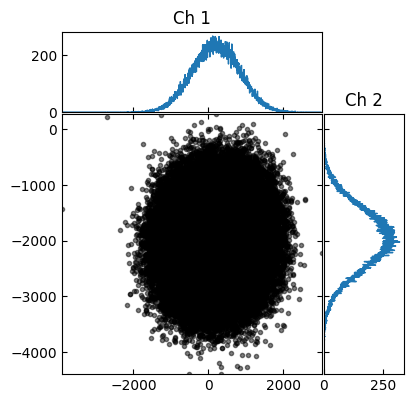

<Figure size 800x800 with 0 Axes>

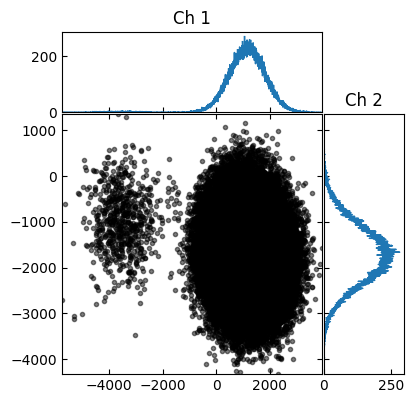

No checkpoint found, starting new optimization.


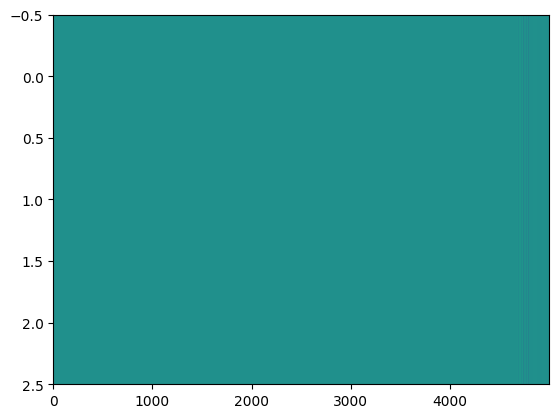

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 5.369946 sec
Captured 15 buffers (2.793324 buffers per sec)
Captured 46080 records (8581.091491 records per sec)
Transferred 754974720 bytes (140592602.991525 bytes per sec)


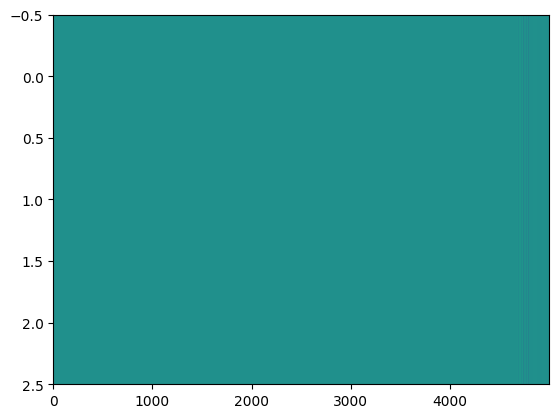

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 5.237187 sec
Captured 15 buffers (2.864133 buffers per sec)
Captured 46080 records (8798.616262 records per sec)
Transferred 754974720 bytes (144156528.836709 bytes per sec)


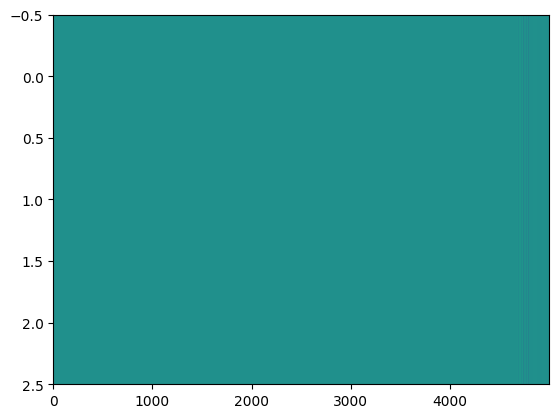

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 5.240567 sec
Captured 15 buffers (2.862285 buffers per sec)
Captured 46080 records (8792.940932 records per sec)
Transferred 754974720 bytes (144063544.227744 bytes per sec)


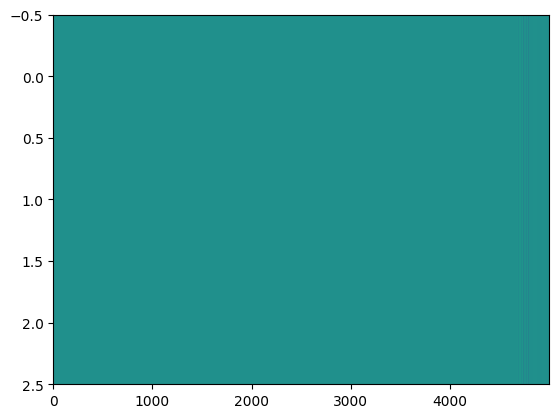

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 5.231002 sec
Captured 15 buffers (2.867520 buffers per sec)
Captured 46080 records (8809.020009 records per sec)
Transferred 754974720 bytes (144326983.832158 bytes per sec)


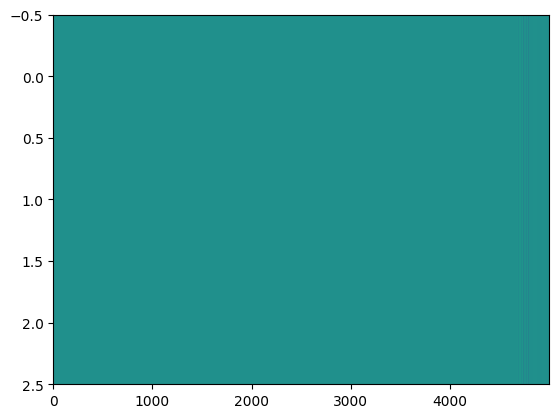

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 5.222908 sec
Captured 15 buffers (2.871963 buffers per sec)
Captured 46080 records (8822.671168 records per sec)
Transferred 754974720 bytes (144550644.412301 bytes per sec)


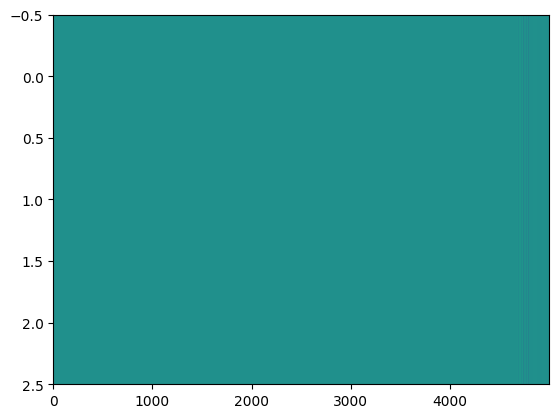

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 10.270170 sec
Captured 15 buffers (1.460541 buffers per sec)
Captured 46080 records (4486.780555 records per sec)
Transferred 754974720 bytes (73511412.608640 bytes per sec)


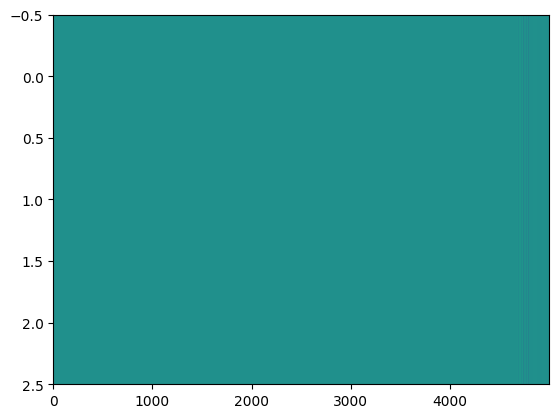

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 5.484374 sec
Captured 15 buffers (2.735043 buffers per sec)
Captured 46080 records (8402.052743 records per sec)
Transferred 754974720 bytes (137659232.142600 bytes per sec)


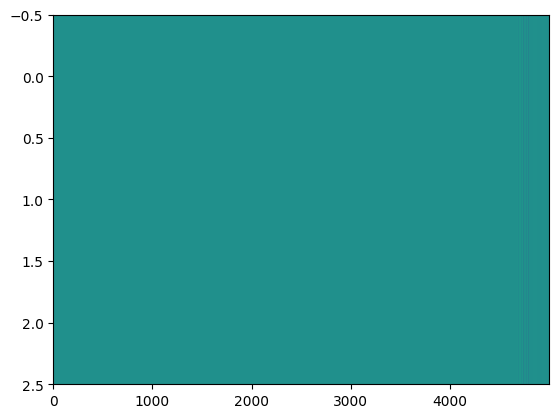

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4


In [ ]:
space = [Real(0.1,1.5, name= 'amp'),Real(15,40, name='pi_ge_time')]
reps = 15000
I1_ground, Q1_ground, I2_ground, Q2_ground = get_ground_IQ(50000)

def minimization_function(params):

    amp, pi_ge_time = params
    I1, Q1, I2, Q2 = pi_ge_tune(
    q1,
    q2,
    general_vals_dict,
    num_steps = 3,
    reps= reps,
    amp=amp,
    pi_ge_time=pi_ge_time)

    # Compute total L2 distance from both qubit IQ references
    err_q1 = (I1_ground - I1)**2 + (Q1_ground - Q1)**2
    err_q2 = (I2_ground - I2)**2 + (Q2_ground - Q2)**2

    return err_q1 + err_q2 


checkpoint_file = "gp_minimize_checkpoint.pkl"
n_calls = 50

# Set up the checkpoint saver
checkpoint_saver = CheckpointSaver(checkpoint_file, compress=9)

# Check if checkpoint exists
if os.path.exists(checkpoint_file):
    print("Resuming from checkpoint...")
    with open(checkpoint_file, "rb") as f:
        checkpoint_result = pickle.load(f)
    x0 = checkpoint_result.x_iters
    y0 = checkpoint_result.func_vals
    already_done = len(x0)
    remaining = n_calls - already_done
    print(f"Already completed: {already_done} calls; Remaining: {remaining}")
    if remaining <= 0:
        print("Optimization already complete.")
        result = checkpoint_result
    else:
        result = gp_minimize(
            func=minimization_function,
            dimensions=space,
            acq_func="EI",
            n_calls=remaining,
            n_initial_points=0,
            noise="gaussian",
            random_state=42,
            x0=x0,
            y0=y0,
            callback=[checkpoint_saver]
        )
else:
    print("No checkpoint found, starting new optimization.")
    result = gp_minimize(
        func=minimization_function,
        dimensions=space,
        acq_func="EI",
        n_calls=n_calls,
        n_initial_points=10,
        noise="gaussian",
        random_state=42,
        callback=[checkpoint_saver]
    )

print("Optimization finished!")
print("Best parameters found:", result.x)
print("Best score:", result.fun)


In [ ]:
print("Optimal amplitude:", result.x[0])
print("Optimal pi_ge_time:", result.x[1])
print("Minimum total IQ error:", result.fun)

NameError: name 'result' is not defined

In [ ]:
I1, Q1, I2, Q2 = pi_ge_tune(
    q1,
    q2,
    general_vals_dict,
    num_steps = 3,
    reps= reps,
    amp=result.x[0],
    pi_ge_time=result.x[1])

NameError: name 'result' is not defined

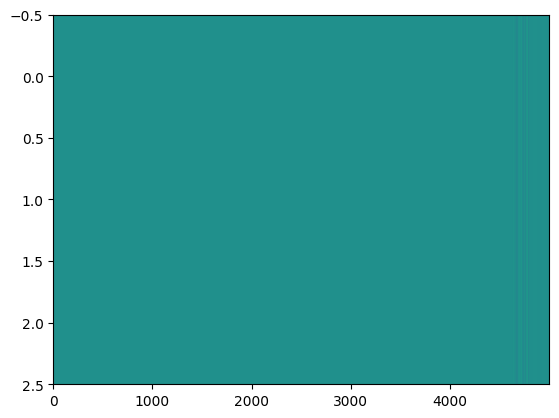

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 10.012033 sec
Captured 15 buffers (1.498197 buffers per sec)
Captured 46080 records (4602.462083 records per sec)
Transferred 754974720 bytes (75406738.774833 bytes per sec)


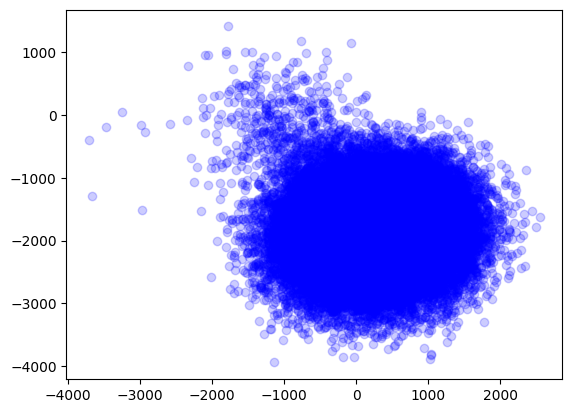

In [ ]:
sweeppiamp.pi_ge_gaussian_tune_iq(
    q1,
    q2,
    general_vals_dict,
    num_steps=3,
    amp=result.x[0],
    pi_ge_time=result.x[1],
    swap_freq=-0.21,
    swap_time=213.58765318403013,
    file_length=16000,
    verbose=True,
    )
num_steps = 3
reps = 15000
wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )
reps =250000
swap_freq= -.0194
swap_time=0.5*7/abs(swap_freq)
phase = 0
swap_amp = 1.36

square_values = pnp.pi_nopi_swap(
            q1,
            q2,
            general_vals_dict,
            copief=0,
            coswap=1,
            copige=0,
            num_steps=3,
            swap_freq=swap_freq,
            swap_time=swap_time,
            phase=phase,
            swap_amp=swap_amp,
        )

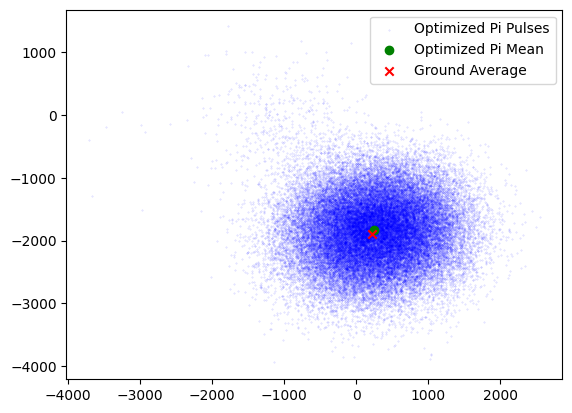

In [ ]:
plt.scatter(values.rec_readout_1[0],values.rec_readout_1[1], label='Optimized Pi Pulses', color='blue', alpha=0.2, s = 0.1)
plt.scatter(square_values.rec_readout_1[0],square_values.rec_readout_1[1], label='Square Pi Pulses', color='orange', alpha=0.2, s = 0.1)
plt.scatter(np.mean(values.rec_readout_1[0]),np.mean(values.rec_readout_1[1]), label='Optimized Pi Mean', color='green')
plt.scatter(np.mean(square_values.rec_readout_1[0]),np.mean(square_values.rec_readout_1[1]), label='Square Pi Mean', color='green', marker = 'p')
plt.scatter(I1_ground,Q1_ground, color='red', marker='x', label = 'Ground Average')
plt.legend()